# Problem: In analysis_data.csv is it possible to find clusters?

Get data:

In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np



from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations


problem_data_path= f"{os.getcwd()}/analysis_data.csv"

problem_data_df = pd.read_csv(problem_data_path)

#are there any duplicates:

if len(problem_data_df)-len(problem_data_df.drop_duplicates())>0:
    print('Duplicates available')
    duplicate = problem_data_df[problem_data_df.duplicated()]



def create_interaction_features(X):


    poly = PolynomialFeatures(interaction_only=True)
    X_inter=poly.fit_transform(X)
    X_inter=pd.DataFrame(data=X_inter)
    original_feature_names = X.columns

    X_inter_df = pd.DataFrame(X_inter, columns=poly.get_feature_names_out(X.columns))
        
        
    interaction_feature_names = []
    for i, feature_name_i in enumerate(original_feature_names):
        for j, feature_name_j in enumerate(original_feature_names[i + 1:]):
            interaction_feature_names.append(f"{feature_name_i}*{feature_name_j}")


    interaction_features = []
    for feature_name_i, feature_name_j in combinations(original_feature_names, 2):
        interaction_features.append(X[feature_name_i] * X[feature_name_j])

    X_inter_df = pd.concat(interaction_features, axis=1)
    X_inter_df.columns = interaction_feature_names

    # Concatenate the original features with the interaction features DataFrame
    X_inter_df = pd.concat([X, X_inter_df], axis=1)

    #remove duplicate column names
    X_inter_df = X_inter_df.loc[:,~X_inter_df.columns.duplicated()].copy()



    return X_inter_df


def create_filter_summary(df,x,y,filter):

    plt.scatter(df[f'{x}'], df[f'{y}'], c=df[f'{filter}'], cmap='viridis')
    plt.colorbar(label=f'{filter}')  # Adds a color bar to show the scale for filter_1
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f"Scatter Plot of {x} vs {y} colored by {filter}")
    plt.show()


    value_counts = df[f'{filter}'].value_counts()

    # Create a DataFrame for percentage and total
    df_summary = pd.DataFrame({
        'value': value_counts.index,
        'total': value_counts.values,
        'percentage': (value_counts.values / len(df)) * 100
    })

    print(df_summary)

We can start by doing a simple **EDA**:

In [42]:
print(problem_data_df.describe())

print("Correlations:")
print(problem_data_df.corr())

                x1           x2           x3           x4           x5
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean      9.169406     6.191567     7.522839     0.534244     2.237132
std       1.073318     1.686931     2.387211     8.118901     3.755256
min       6.001301     0.404893     0.532465   -12.999125    -7.817603
25%       8.457069     5.034477     5.798231    -7.351003    -1.080763
50%       9.197038     6.240756     7.734570     1.514249     3.295247
75%       9.896599     7.405013     9.355011     8.493498     5.552383
max      12.250169    10.947153    13.706628    11.358456     8.990172
Correlations:
          x1        x2        x3        x4        x5
x1  1.000000  0.208321  0.031741 -0.205139 -0.095110
x2  0.208321  1.000000  0.628025  0.643832  0.645143
x3  0.031741  0.628025  1.000000  0.792783  0.747042
x4 -0.205139  0.643832  0.792783  1.000000  0.883959
x5 -0.095110  0.645143  0.747042  0.883959  1.000000


From this we can see that x1-x3 are **"similar"** with all values >0. x4 and x5 are different with smaller **means**, higher **stds** and also has **values<0**.

To further investigate this, histograms are created:

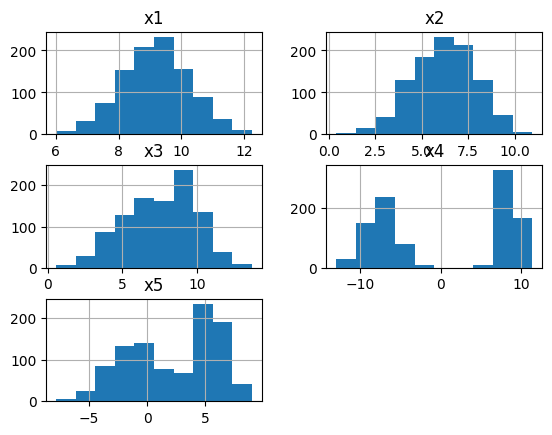

In [43]:
problem_data_df.hist()
plt.show()

And scatterplots

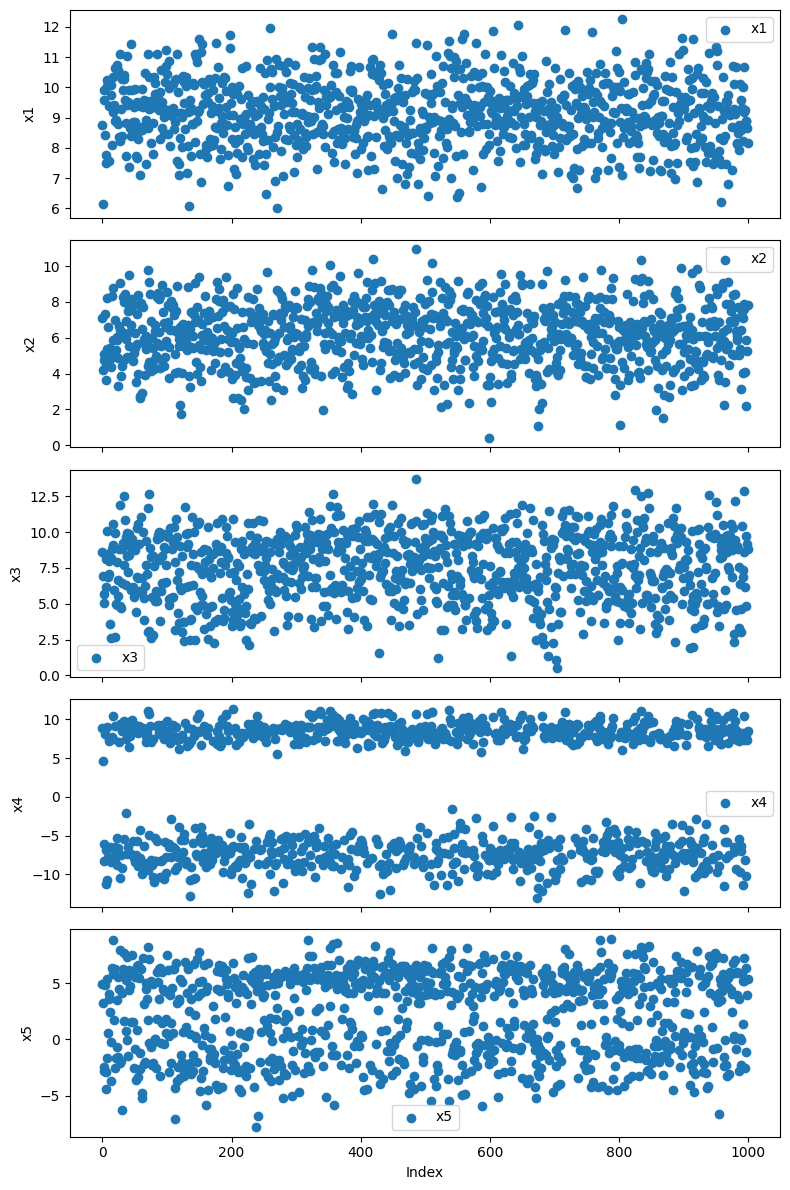

<Figure size 1000x500 with 0 Axes>

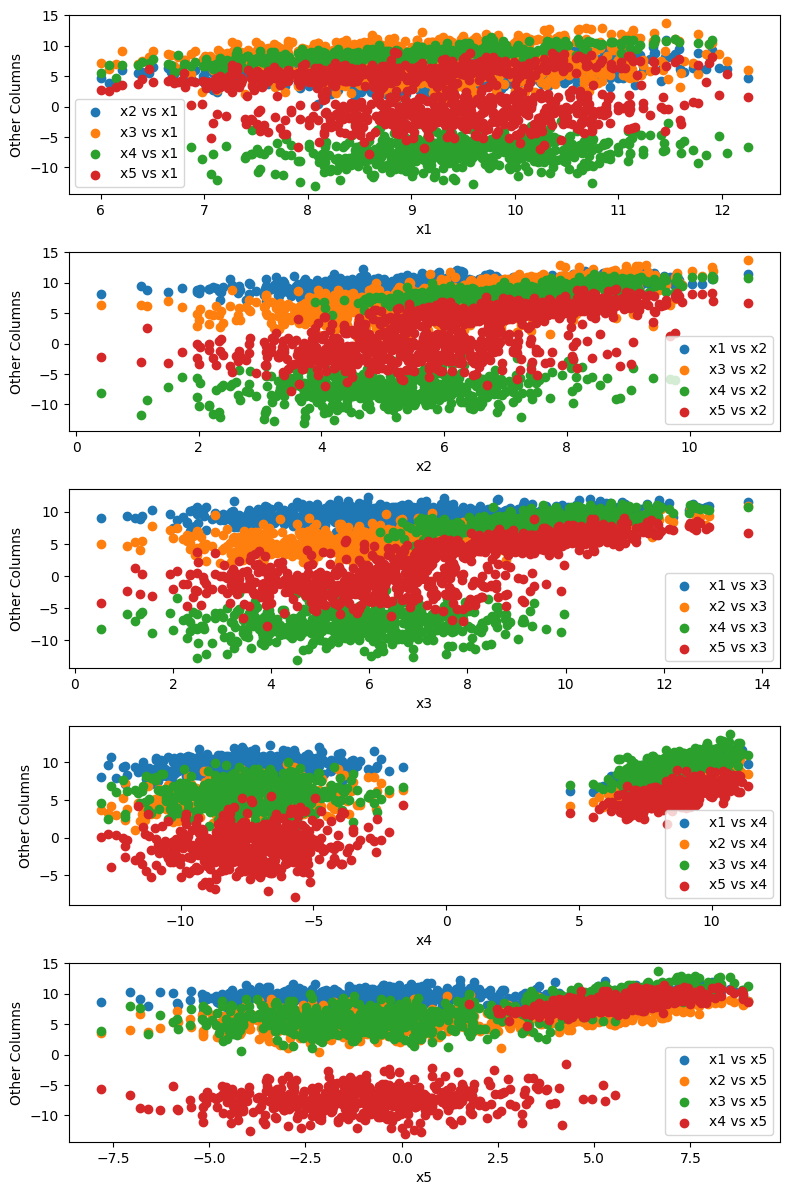

In [44]:

fig, axes = plt.subplots(5, 1, figsize=(8, 12), sharex=True)

columns = ['x1', 'x2', 'x3', 'x4', 'x5']


for i, col in enumerate(columns):
    axes[i].scatter(problem_data_df.index, problem_data_df[col], label=col)
    axes[i].set_ylabel(col)
    axes[i].legend()

axes[-1].set_xlabel('Index')

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(5, 1, figsize=(8, 12), sharex=False)



for i, x_col in enumerate(columns):
    for y_col in columns:
        if x_col != y_col:
            axes[i].scatter(problem_data_df[x_col], problem_data_df[y_col], label=f"{y_col} vs {x_col}")
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel("Other Columns")
    axes[i].legend()

plt.tight_layout()
plt.show()

A simple filter is created by using **x4>0 and x4<0**, we call this **filter_1**:

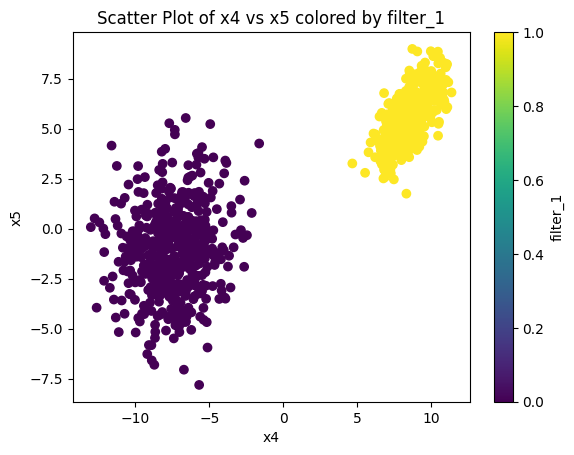

   value  total  percentage
0      1    500        50.0
1      0    500        50.0


In [45]:
problem_data_df['filter_1'] = np.where(problem_data_df['x4']> 0, 1, 0)


create_filter_summary(problem_data_df,'x4','x5','filter_1')

**filter_1 equally separates the data.**

**filter_2** is created based on x5 and x4:

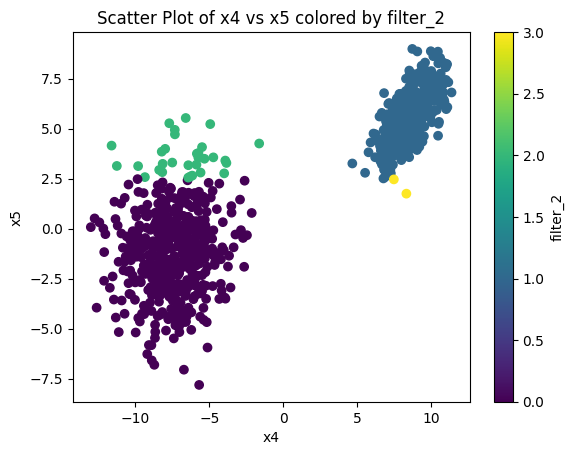

   value  total  percentage
0      1    498        49.8
1      0    469        46.9
2      2     31         3.1
3      3      2         0.2


In [46]:
conditions = [
    (problem_data_df['x4'] > 0) & (problem_data_df['x5'] > 2.5),
    (problem_data_df['x4'] <= 0) & (problem_data_df['x5'] > 2.5),
    (problem_data_df['x4'] > 0) & (problem_data_df['x5'] <= 2.5)
]


values = [1, 2, 3] 

problem_data_df['filter_2'] = np.select(conditions, values, default=0)


create_filter_summary(problem_data_df,'x4','x5','filter_2')

**filter_2** further separates the data into 4 parts. One problem is that the different clusters are a little bit overlapping.

To find more filter we can create new parameters from our 5 paramters (x1,x2,x3,x5) simply by combining them. One way of doing this can be with interaction parameters or by dividing them:

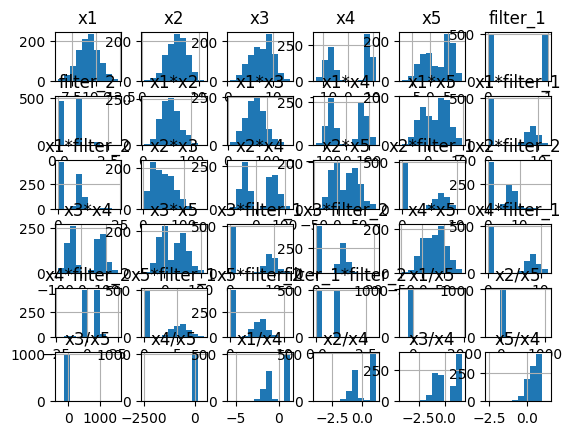

In [47]:
problem_data_df_inter=create_interaction_features(problem_data_df)

problem_data_df_inter['x1/x5']=problem_data_df_inter['x1']/problem_data_df_inter['x5']
problem_data_df_inter['x2/x5']=problem_data_df['x2']/problem_data_df_inter['x5']
problem_data_df_inter['x3/x5']=problem_data_df['x3']/problem_data_df_inter['x5']
problem_data_df_inter['x4/x5']=problem_data_df['x4']/problem_data_df_inter['x5']

problem_data_df_inter['x1/x4']=problem_data_df_inter['x1']/problem_data_df_inter['x4']
problem_data_df_inter['x2/x4']=problem_data_df['x2']/problem_data_df_inter['x4']
problem_data_df_inter['x3/x4']=problem_data_df['x3']/problem_data_df_inter['x4']
problem_data_df_inter['x5/x4']=problem_data_df['x5']/problem_data_df_inter['x4']

problem_data_df_inter.hist()
plt.show()

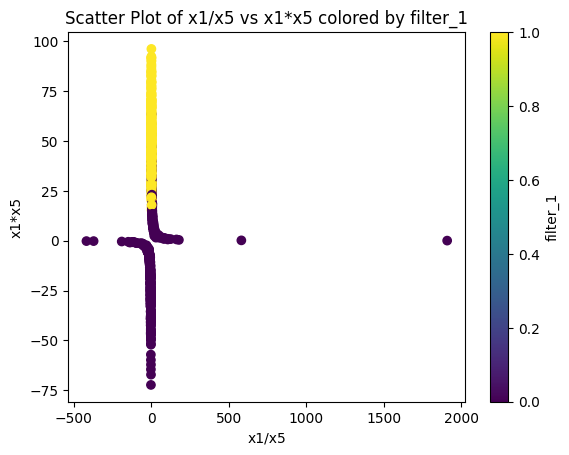

   value  total  percentage
0      1    500        50.0
1      0    500        50.0


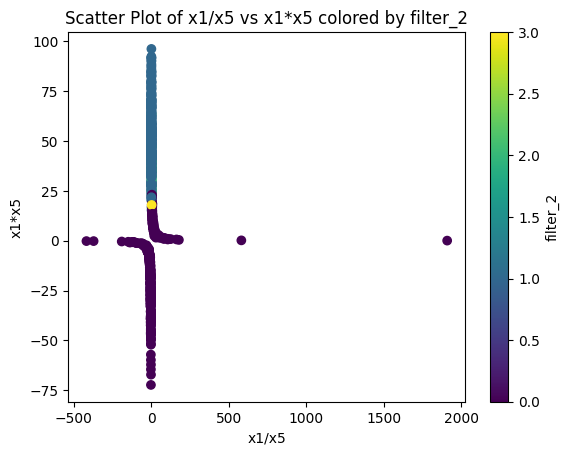

   value  total  percentage
0      1    498        49.8
1      0    469        46.9
2      2     31         3.1
3      3      2         0.2


In [48]:
create_filter_summary(problem_data_df_inter,'x1/x5','x1*x5','filter_1')
create_filter_summary(problem_data_df_inter,'x1/x5','x1*x5','filter_2')

We can see that this separates the data into new ways compared to **filter_1** and **filter_2**.

We can create **filter_3** as x1/x5 >500 or x1/x5<-200

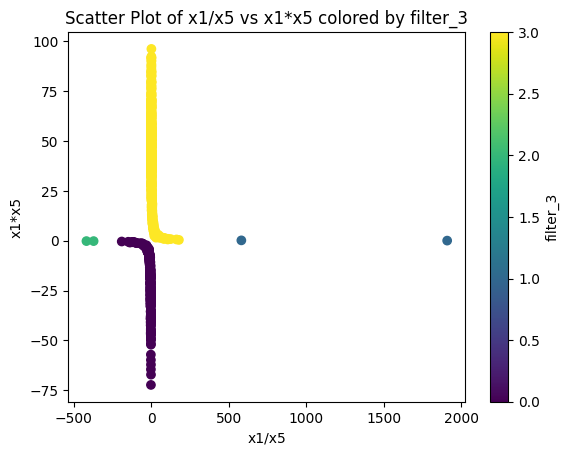

   value  total  percentage
0      3    654        65.4
1      0    342        34.2
2      1      2         0.2
3      2      2         0.2


In [49]:
conditions = [
    (problem_data_df_inter['x1/x5'] > 500) ,
    (problem_data_df_inter['x1/x5'] < -200),
    (problem_data_df_inter['x1/x5'] > 0) & (problem_data_df_inter['x1/x5'] <= 500)
]

values = [1,2,3] 

problem_data_df_inter['filter_3'] = np.select(conditions, values, default=0)

create_filter_summary(problem_data_df_inter,'x1/x5','x1*x5','filter_3')


Another thing we can try is to convert from cartesian coordinates to polar:

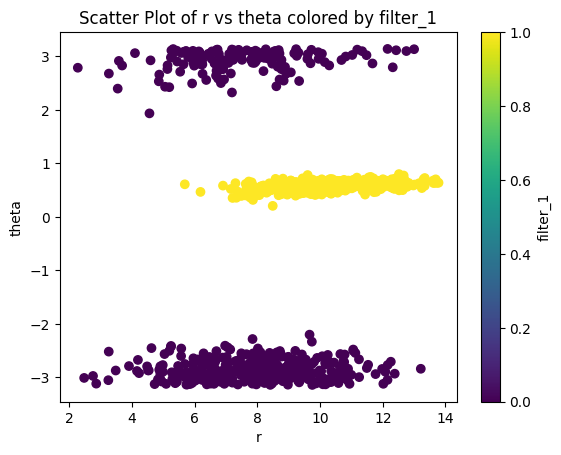

   value  total  percentage
0      1    500        50.0
1      0    500        50.0


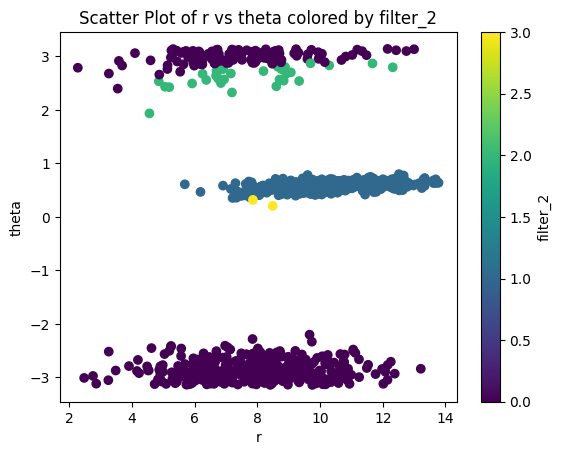

   value  total  percentage
0      1    498        49.8
1      0    469        46.9
2      2     31         3.1
3      3      2         0.2


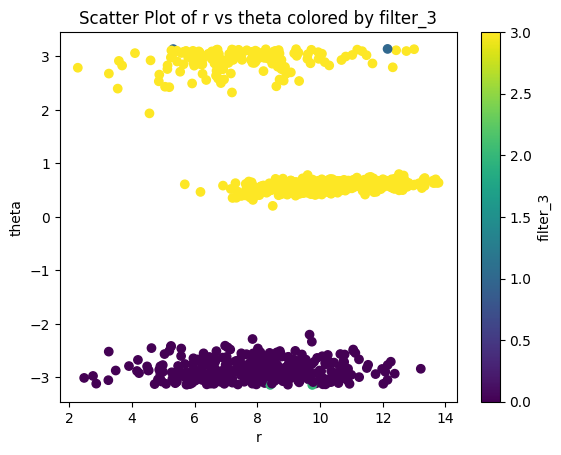

   value  total  percentage
0      3    654        65.4
1      0    342        34.2
2      1      2         0.2
3      2      2         0.2


In [50]:


problem_data_df_inter['r'] = np.sqrt(problem_data_df_inter['x4']**2 + problem_data_df_inter['x5']**2)
problem_data_df_inter['theta'] = np.arctan2(problem_data_df_inter['x5'], problem_data_df_inter['x4'])


create_filter_summary(problem_data_df_inter,'r','theta','filter_1')
create_filter_summary(problem_data_df_inter,'r','theta','filter_2')
create_filter_summary(problem_data_df_inter,'r','theta','filter_3')

We can see that this can create other clusters from **filter_1**, **filter_2** and **filter_3**.

**filter_4** is defined by theta>1 or theta<0

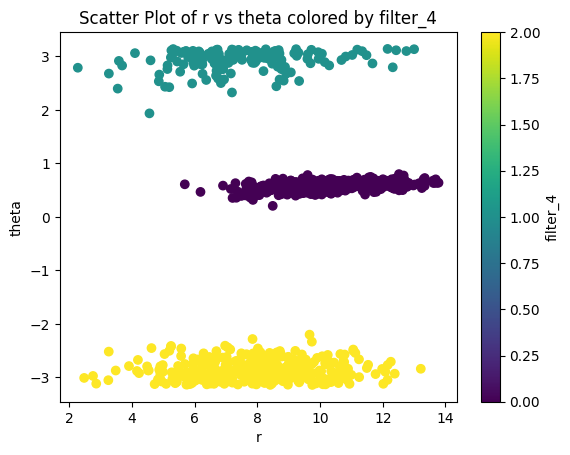

   value  total  percentage
0      0    500        50.0
1      2    344        34.4
2      1    156        15.6


In [51]:
conditions = [
    (problem_data_df_inter['theta'] > 1) ,
    (problem_data_df_inter['theta'] < 0) 
]


values = [1, 2] 

problem_data_df_inter['filter_4'] = np.select(conditions, values, default=0)


create_filter_summary(problem_data_df_inter,'r','theta','filter_4')

# Solution: Yes, we have 4 filters to choose among that creates the following clusters:

**filter 1:**

| cluster | total | percentage |
| -------- | ------- | ------- |
|0|500|50.0|
|1|500|50.0|

**filter 2:**


| cluster | total | percentage |
| -------- | ------- | ------- |
|0|469|49.8|
|1|498|46.9|
|2|31|3.1|
|3|2|0.2|


**filter 3:**


| cluster| total | percentage |
| -------- | ------- | ------- |
|0|342|34.2|
|1|2|0.2|
|2|2|0.2|
|3|654|65.4|



**filter 4:**

| cluster | total | percentage |
| -------- | ------- | ------- |
|0|500|50.0|
|1|156|15.6|
|2|344|34.4|


